In [492]:
import importlib
import json
import os
import sys
import warnings

import matplotlib.pyplot as plt

from collections import Counter

import numpy as np
import tensorflow as tf

from tensorflow.keras import Model, layers, optimizers, losses
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from music21 import environment, stream, converter

environment.set('midiPath', '/usr/bin/timidity')

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

# Всё, что выводит CUDA / XLA, будет записано в файл
sys.stderr = open("xla_warnings.log", "w")



sys.path.append('src')

# в режиме редактирования сбрасуем кэшь иначе не видно изменений
for module in [
    "utils.music21_utils",
    "utils.data_utils",
    "utils.model_utils",
    "utils.generate_utils",
    "utils.train_utils",
    "utils.__init__"
    
]:
    imported_module = importlib.import_module(module)
    importlib.reload(imported_module)


from utils.__init__ import (
    get_midis_from_folder,
    # get_midis_by_compositor,
    get_notes_multitrack,
    get_notes_multitrack,
    midi_to_notes,
    compute_global_stats,
    process_midi_for_training,
    build_triple_output_transformer,
    generate_full_autoregressive,
    denormalize_sequence_global,
    process_midi,
    split_parts_basic,
    prepare_sequences,
    check_step_dur,
    split_encoder_input,
    align_timelines, 
    save_multi_track_midi,
    get_all_midis,
    midi_to_notes, split_parts_by_onset,
    notes_with_offsets_from_midi
)

#from utils.constants import NUM_PITCHES

## Загрузка midi по композитору

In [2]:
#mozart_midis = get_midis_from_folder("../dataset/Mozart")
#bach_midis   = get_midis_from_folder("../dataset/Bach")
#albeniz_midis = get_midis_from_folder("../dataset/Albeniz")
#rach_midis    = get_midis_from_folder("../dataset/Rachmaninoff")

#all_pretrain_midis = mozart_midis + bach_midis + albeniz_midis + rach_midis

In [4]:
all_pretrain_midis = get_all_midis("../dataset")

## 2. Глобальная статистика

In [399]:
all_notes = []
for midi in all_pretrain_midis:
    all_notes.extend(midi_to_notes(midi))

In [480]:
midi_to_notes(all_pretrain_midis[0])

[{'pitch': 70, 'step': 0.0, 'duration': 2.0},
 {'pitch': 58, 'step': 0.0, 'duration': 0.5},
 {'pitch': 65, 'step': 0.5, 'duration': 0.5},
 {'pitch': 62, 'step': 0.5, 'duration': 0.5},
 {'pitch': 65, 'step': 0.5, 'duration': 0.5},
 {'pitch': 74, 'step': 0.5, 'duration': 0.5},
 {'pitch': 58, 'step': 0.0, 'duration': 0.5},
 {'pitch': 75, 'step': 0.5, 'duration': 0.25},
 {'pitch': 65, 'step': 0.0, 'duration': 0.5},
 {'pitch': 72, 'step': 0.25, 'duration': 0.25},
 {'pitch': 74, 'step': 0.25, 'duration': 0.5},
 {'pitch': 62, 'step': 0.0, 'duration': 0.5},
 {'pitch': 75, 'step': 0.5, 'duration': 0.5},
 {'pitch': 65, 'step': 0.0, 'duration': 0.5},
 {'pitch': 76, 'step': 0.5, 'duration': 1.5},
 {'pitch': 57, 'step': 0.0, 'duration': 0.5},
 {'pitch': 65, 'step': 0.5, 'duration': 0.5},
 {'pitch': 60, 'step': 0.5, 'duration': 0.5},
 {'pitch': 77, 'step': 0.5, 'duration': 0.5},
 {'pitch': 65, 'step': 0.0, 'duration': 0.5},
 {'pitch': 72, 'step': 0.5, 'duration': 0.5},
 {'pitch': 57, 'step': 0.0, 'd

In [91]:
count_num = Counter([note['pitch'] for note in all_notes])

In [93]:
# Ключ в словаре - имена нот
# Значение в словаре - их количество

Notes = list(count_num.keys())
Recurrence = list(count_num.values())

# Средняя частота встречаемости нот в корпусе
def Average(rec):
    return sum(rec) / len(rec)

print('Средняя повторяемость ноты:', Average(Recurrence))
print('Наиболее часто встречаемые ноты:', max(Recurrence), 'раз')
print('Наиболее редкие ноты:', min(Recurrence), 'раз')

Средняя повторяемость ноты: 6199.827586206897
Наиболее часто встречаемые ноты: 18356 раз
Наиболее редкие ноты: 2 раз


In [94]:
# Получение списка редких нот
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)

print("Общее число нот, которые повторяются менее 100 раз:", len(rare_note))

Общее число нот, которые повторяются менее 100 раз: 9


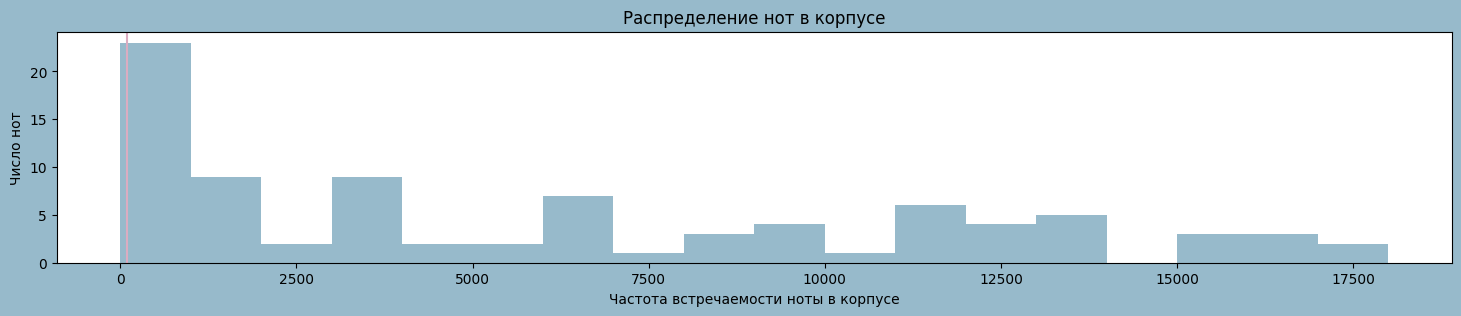

In [400]:
plt.figure(figsize=(18, 3), facecolor='#97BACB')
bins = np.arange(0,(max(Recurrence)), 1000)
plt.hist(Recurrence, bins=bins, color='#97BACB')
plt.axvline(x=100, color='#DBACC1') # отсечка по встречаемости в 100 раз
plt.title('Распределение нот в корпусе')
plt.xlabel('Частота встречаемости ноты в корпусе')
plt.ylabel('Число нот')
plt.show()

In [97]:
for element in all_notes:
    if element['pitch'] in rare_note:
        all_notes.remove(element)

print("Длина корпуса после исключения редких нот:", len(all_notes))

Длина корпуса после исключения редких нот: 539096


In [98]:
stats = compute_global_stats(all_notes)
print("Global stats:", stats)

pitch_offset = int(stats["pitch_min"])  # обязательный
step_max = stats["step_max"]
dur_max = stats["dur_max"]

Global stats: {'pitch_min': 24.0, 'pitch_max': 101.0, 'step_max': 2.0, 'dur_max': 3.0}


## 3. Подготовка данных

In [231]:
from music21 import note, duration
from fractions import Fraction
# Функция преобразования отрывка из корпуса обратно в поток
def chords_n_notes(chunk):
    Melody = []
    offset = 0 # счетчик
    for i in chunk:
        # Если это аккорд разделенный точкой
        note_chunk = note.Note(i['pitch'])
        # задаем позицию ноты
        note_chunk.offset = i['step'] if i['step'] else 0.5
        #note_chunk.offset = offset + i['step']
        note_chunk.duration = duration.Duration(i['duration'])
        # print(note_chunk.step)
        Melody.append(note_chunk)
        # увеличиваем номер позиции
        offset += 1


    return Melody

# Преобразуем последовательность из 100 нот обратно в поток Stream
Music = chords_n_notes(all_notes[100:200])
Melody_midi = stream.Stream(Music)

In [149]:
from music21 import environment

# настраиваем окружение в соответствии с документацией
us = environment.UserSettings()
us['musescoreDirectPNGPath'] = '/usr/bin/mscore3'
us['directoryScratch'] = '/tmp'

In [180]:
Melody_midi.show('midi')

Playing /tmp/tmpimakzj1u.mid
MIDI file: /tmp/tmpimakzj1u.mid
Format: 1  Tracks: 2  Divisions: 10080
Track name: 
Playing time: ~54 seconds
Notes cut: 0
Notes lost totally: 0


In [402]:
SEQ_LEN = 50
ENC_LEN = 100

enc_inputs = []
dec_inputs = []
pitch_targets = []
step_targets = []
dur_targets = []

### Обрабатываем MIDI

In [403]:
for midi in all_pretrain_midis:
    out = process_midi(
        midi, stats, pitch_offset,
        rare_note=rare_note,
        seq_len=SEQ_LEN, L_enc=ENC_LEN
    )
    if out is None:
        continue
    
    E, D, p, s, d = out
    
    enc_inputs.append(E)
    dec_inputs.append(D)
    pitch_targets.append(p)
    step_targets.append(s)
    dur_targets.append(d)

## 4. Конкатенация

In [405]:
enc_inputs = np.concatenate(enc_inputs)
dec_inputs = np.concatenate(dec_inputs)

pitch_targets = np.concatenate(pitch_targets)   # (N, L_dec)
step_targets  = np.concatenate(step_targets)    # (N, L_dec, 1)
dur_targets   = np.concatenate(dur_targets)     # (N, L_dec, 1)

N = enc_inputs.shape[0]
L_dec = dec_inputs.shape[1]


## 5. Маскируем не таргетные токены правильно

### Pitch (целые индексы, без -1)

In [406]:
pitch_targets_full = pitch_targets.copy()

# НО: здесь важный трюк. Мы обучаем ТОЛЬКО последний токен:
mask = np.zeros((N, L_dec), dtype=np.float32)
mask[:, -1] = 1.0

### Step / Duration

In [407]:
step_targets_full = step_targets.copy()
dur_targets_full = dur_targets.copy()

## 6. Компиляция модели

In [408]:
model = build_triple_output_transformer()

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss={
        "pitch_out": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        "step_out": "mse",
        "duration_out": "mse"
    },
    metrics={
        "pitch_out": "accuracy",
        "step_out": "mse",
        "duration_out": "mse"
    }
)

## 7. Обучение

In [409]:
history = model.fit(
    [enc_inputs, dec_inputs],
    [pitch_targets_full, step_targets_full, dur_targets_full],
    sample_weight=[mask, mask, mask],
    batch_size=64,
    epochs=120,
    validation_split=0.1,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            "pretrain_checkpoint.keras",
            save_best_only=True,
            monitor="val_loss",
            mode="min"
        )
    ]
)

Epoch 1/120
87/87 ━━━━━━━━━━━━━━━━━━━━ 51s 307ms/step - duration_out_loss: 0.0383 - duration_out_mse: 1.9196 - loss: 0.1191 - pitch_out_accuracy: 0.0405 - pitch_out_loss: 0.0778 - step_out_loss: 0.0029 - step_out_mse: 0.1451 - val_duration_out_loss: 0.0277 - val_duration_out_mse: 1.3085 - val_loss: 0.1114 - val_pitch_out_accuracy: 0.0323 - val_pitch_out_loss: 0.0825 - val_step_out_loss: 0.0023 - val_step_out_mse: 0.1101
Epoch 2/120
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - duration_out_loss: 0.0383 - duration_out_mse: 1.9233 - loss: 0.1147 - pitch_out_accuracy: 0.0476 - pitch_out_loss: 0.0734 - step_out_loss: 0.0028 - step_out_mse: 0.1417 - val_duration_out_loss: 0.0277 - val_duration_out_mse: 1.3085 - val_loss: 0.1112 - val_pitch_out_accuracy: 0.0323 - val_pitch_out_loss: 0.0825 - val_step_out_loss: 0.0023 - val_step_out_mse: 0.1101
Epoch 3/120
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - duration_out_loss: 0.0384 - duration_out_mse: 1.9233 - loss: 0.1144 - pitch_out_accuracy: 0.0448 - p

## 7. ЗАГРУЖАЕМ PRETRAIN МОДЕЛЬ И ДООБУЧАЕМ НА ШОПЕНЕ

### 3. Подготовка данных

In [410]:
enc_inputs_ch = []
dec_inputs_ch = []
pitch_ch = []
step_ch = []
dur_ch = []

### Обрабатываем MIDI

In [411]:
chopin_midis = get_midis_from_folder("../dataset/Chopin")

In [342]:
groups = defaultdict(list)

In [314]:
melodies_, chords_, basses_ = [], [], []

In [353]:
melody_1, chords_1, bass_1 = [], [], []

In [343]:
for chopin_ in chopin_midis:
    midi_ = converter.parse(chopin_)
    notes_ = midi_to_notes(midi_)
    melody, chords, bass  = split_parts_by_onset(notes_)
    melodies_.append(melody)
    chords_.append(chords)
    basses_.append(bass)

In [345]:
notes_ = notes_with_offsets_from_midi(notes_)

In [351]:
n = notes_[5]
o = float(n["offset"])
key = round(o / quant)  # integer bucket
groups[key].append(n)
groups[key] = n

In [354]:
for key in sorted(groups.keys()):
    grp = groups[key]
    print(grp)

{'pitch': 43, 'step': 0.0, 'duration': 0.25, 'offset': 0.0}
{'pitch': 55, 'step': 0.5, 'duration': 0.25, 'offset': 0.5}
{'pitch': 57, 'step': 0.25, 'duration': 0.25, 'offset': 0.75}
{'pitch': 59, 'step': 0.25, 'duration': 0.25, 'offset': 1.0}
{'pitch': 57, 'step': 0.25, 'duration': 0.25, 'offset': 1.25}
{'pitch': 55, 'step': 0.25, 'duration': 0.25, 'offset': 1.5}


In [357]:
pitches_ = [x["pitch"] for x in grp]

{'pitch': 55, 'step': 0.25, 'duration': 0.25, 'offset': 1.5}

In [365]:
grp = [{'pitch': 81, 'step': 0.25, 'duration': 0.25, 'offset': 250.0}, {'pitch': 39, 'step': 0.0, 'duration': 0.25, 'offset': 250.0}]

In [366]:
pitches = [x["pitch"] for x in grp]

In [367]:
max_idx = int(np.argmax(pitches))
min_idx = int(np.argmin(pitches))

In [370]:
grp[max_idx]

{'pitch': 81, 'step': 0.25, 'duration': 0.25, 'offset': 250.0}

In [412]:
# ---------------------------
# 3. Генерируем enc/dec и targets для fine-tune
# ---------------------------

for midi_path in chopin_midis:
    midi = converter.parse(midi_path)
    out = process_midi(midi, stats, pitch_offset,
                   rare_note=rare_note,
                   seq_len=50, L_enc=100,
                   normalization=True)
    if out is None:
        continue
    E, D, p, s, d = out
    enc_inputs_ch.append(E)
    dec_inputs_ch.append(D)
    pitch_ch.append(p)
    step_ch.append(s)
    dur_ch.append(d)

In [413]:
check_step_dur(step_ch, dur_ch, stats["step_max"], stats["dur_max"])
pitch_min = min(int(x.min()) for x in pitch_ch)
pitch_max = max(int(x.max()) for x in pitch_ch)

print("pitch min:", pitch_min, "pitch max:", pitch_max)
print("pretrain max class:", stats['pitch_max'] - stats['pitch_min'])

=== CHECK STEP ===
min: 0.0
max: 2.0
NaN: 0
negatives: 0
out_of_range: 0

=== CHECK DURATION ===
min: 0.083333336
max: 3.0
NaN: 0
negatives: 0
out_of_range: 0
pitch min: 13 pitch max: 68
pretrain max class: 77.0


In [414]:
enc_inputs_ch_target = np.concatenate(enc_inputs_ch)
dec_inputs_ch_target = np.concatenate(dec_inputs_ch)

pitch_ch_target = np.concatenate(pitch_ch)   # (N, L_dec)
step_ch_target  = np.concatenate(step_ch)    # (N, L_dec, 1)
dur_ch_target   = np.concatenate(dur_ch)     # (N, L_dec, 1)

N_CH = dec_inputs_ch_target.shape[0]
L_dec_CH = dec_inputs_ch_target.shape[1]

In [415]:
enc_melody, enc_bass = split_encoder_input(enc_inputs_ch_target, seq_len=50)

In [416]:
model = tf.keras.models.load_model("pretrain_checkpoint.keras")

# компилируем с меньшим lr
model.compile(
    optimizer=tf.keras.optimizers.Adam(2e-5),
    loss={
        "pitch_out": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        "step_out": "mse",
        "duration_out": "mse"
    },
    metrics={
        "pitch_out": "accuracy",
        "step_out": "mse",
        "duration_out": "mse"
    }
)

ckpt_finetune = tf.keras.callbacks.ModelCheckpoint(
    "chopin_finetuned.keras",
    save_best_only=True,
    monitor="val_loss",
    mode="min"
)

In [417]:
sample_weight_pitch = np.ones((enc_inputs_ch_target.shape[0], dec_inputs_ch_target.shape[1]))

In [418]:
history = model.fit(
    [enc_inputs_ch_target, dec_inputs_ch_target],
    [pitch_ch_target, step_ch_target, dur_ch_target],
    sample_weight=[sample_weight_pitch, sample_weight_pitch, sample_weight_pitch],
    batch_size=16,
    epochs=50,
    validation_split=0.1
)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 48s 521ms/step - duration_out_loss: 0.3320 - duration_out_mse: 0.3332 - loss: 3.4663 - pitch_out_accuracy: 0.1692 - pitch_out_loss: 3.0232 - step_out_loss: 0.1112 - step_out_mse: 0.1119 - val_duration_out_loss: 0.2441 - val_duration_out_mse: 0.2505 - val_loss: 4.2720 - val_pitch_out_accuracy: 0.0632 - val_pitch_out_loss: 4.0538 - val_step_out_loss: 0.0214 - val_step_out_mse: 0.0213
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - duration_out_loss: 0.3113 - duration_out_mse: 0.3126 - loss: 3.3240 - pitch_out_accuracy: 0.1935 - pitch_out_loss: 2.9000 - step_out_loss: 0.1065 - step_out_mse: 0.1070 - val_duration_out_loss: 0.2290 - val_duration_out_mse: 0.2359 - val_loss: 4.2897 - val_pitch_out_accuracy: 0.0555 - val_pitch_out_loss: 4.0971 - val_step_out_loss: 0.0195 - val_step_out_mse: 0.0193
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - duration_out_loss: 0.2894 - duration_out_mse: 0.2907 - loss: 3.2279 - pitch_out_accuracy: 0.1977 - pitc

## Генерация

In [483]:
# ---------------------------
# 1. Берем энкодер вход (мелодию/бас)
# ---------------------------
enc_inputs_ch_input = enc_inputs_ch_target[0:1]  # shape: (1, L_enc, F_enc)

# ---------------------------
# 2. Стартовый токен для декодера
# ---------------------------
seed_dec = np.zeros((1, 1, 3), dtype=np.float32)  # pitch=0, step=0, dur=0

# ---------------------------
# 3. Генерация последовательности
# ---------------------------

# 4) generation
generated_norm = generate_full_autoregressive(
    model, enc_inputs_ch_input, seed_dec, length=64,
    pitch_temp=0.9,
    cont_temp=0.02,
    cont_scale={'step': stats['step_max'], 'dur': stats['dur_max']},
    sampling_mode='stochastic',
    stats=stats
)
# ---------------------------
# 4. Денормализация к исходным значениям
# ---------------------------
generated_denorm = denormalize_sequence_global(generated_norm, stats)

In [484]:
# generated_denorm теперь shape = (1, length_to_generate+1, 3)
# первый шаг — seed_dec, последующие — сгенерированные
pitch_seq = generated_denorm[0, 1:, 0]  # исключаем seed
step_seq  = generated_denorm[0, 1:, 1]
dur_seq   = generated_denorm[0, 1:, 2]

print("Pitch:", pitch_seq)
print("Step :", step_seq)
print("Dur  :", dur_seq)

Pitch: [13. 13. 18. 32. 37. 44. 32. 32. 27. 37. 32. 37. 32. 32. 42. 13. 32. 37.
 13. 28. 13. 13. 13. 13. 20. 13. 13. 21. 13. 13. 13. 42. 13. 42. 13. 13.
 13. 18. 13. 20. 20. 13. 13. 13. 13. 13. 13. 13. 13. 13. 19. 36. 13. 13.
 13. 13. 21. 13. 13. 20. 21. 13. 13. 20.]
Step : [0.0000000e+00 3.8394760e-02 3.8394760e-02 7.6789521e-02 1.5357904e-01
 3.0715808e-01 6.1431617e-01 1.2286323e+00 2.4890225e+00 4.9462872e+00
 9.8925743e+00 1.9785149e+01 3.9570297e+01 7.9547401e+01 1.5923909e+02
 3.1896173e+02 6.3780457e+02 1.2757965e+03 2.5519565e+03 5.1041323e+03
 1.0208307e+04 2.0416541e+04 4.0832891e+04 8.1666086e+04 1.6333202e+05
 3.2666403e+05 6.5332812e+05 1.3066562e+06 2.6133128e+06 5.2266255e+06
 1.0453252e+07 2.0906504e+07 4.1813008e+07 8.3626016e+07 1.6725203e+08
 3.3450406e+08 6.6900813e+08 1.3380163e+09 2.6760325e+09 5.3520650e+09
 1.0704130e+10 2.1408260e+10 4.2816520e+10 8.5633040e+10 1.7126608e+11
 3.4253216e+11 6.8506432e+11 1.3701286e+12 2.7402573e+12 5.4805146e+12
 1.0961029e+13 

## Сохранение midi

In [485]:
# выравниваем — правильно
mel, bass, gen_aligned = align_timelines(enc_melody[0], enc_bass[0], generated_denorm[0])

In [493]:
save_multi_track_midi(mel, bass, gen_aligned, "3_track.mid")

'3_track.mid'

In [490]:
dir(instrument)

['Accordion',
 'AcousticBass',
 'AcousticGuitar',
 'Agogo',
 'Alto',
 'AltoSaxophone',
 'Bagpipes',
 'Banjo',
 'Baritone',
 'BaritoneSaxophone',
 'Bass',
 'BassClarinet',
 'BassDrum',
 'BassTrombone',
 'Bassoon',
 'BongoDrums',
 'BrassInstrument',
 'Castanets',
 'Celesta',
 'Choir',
 'ChurchBells',
 'Clarinet',
 'Clavichord',
 'Conductor',
 'CongaDrum',
 'Contrabass',
 'Contrabassoon',
 'Cowbell',
 'CrashCymbals',
 'Cymbals',
 'Dulcimer',
 'ElectricBass',
 'ElectricGuitar',
 'ElectricOrgan',
 'ElectricPiano',
 'EnglishHorn',
 'FingerCymbals',
 'Flute',
 'FretlessBass',
 'Glockenspiel',
 'Gong',
 'Guitar',
 'Handbells',
 'Harmonica',
 'Harp',
 'Harpsichord',
 'HiHatCymbal',
 'Horn',
 'Instrument',
 'InstrumentException',
 'Iterable',
 'Kalimba',
 'KeyboardInstrument',
 'Koto',
 'Lute',
 'MIDI_PROGRAM_TO_INSTRUMENT',
 'Mandolin',
 'Maracas',
 'Marimba',
 'MezzoSoprano',
 'Oboe',
 'Ocarina',
 'OffsetTree',
 'OrderedDict',
 'Organ',
 'PanFlute',
 'Percussion',
 'Piano',
 'Piccolo',
 'PipeO